In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
from datetime import datetime, timedelta

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


#### Sample
AE Downstream: 2749, 8
\
AE Upstream: 2504, 896
\
CE Downstream: 1394, 382
\
CE Upstream: 1967, 926 (reasonable)

In [3]:
sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]


Text(0, 0.5, 'Latitude °N')

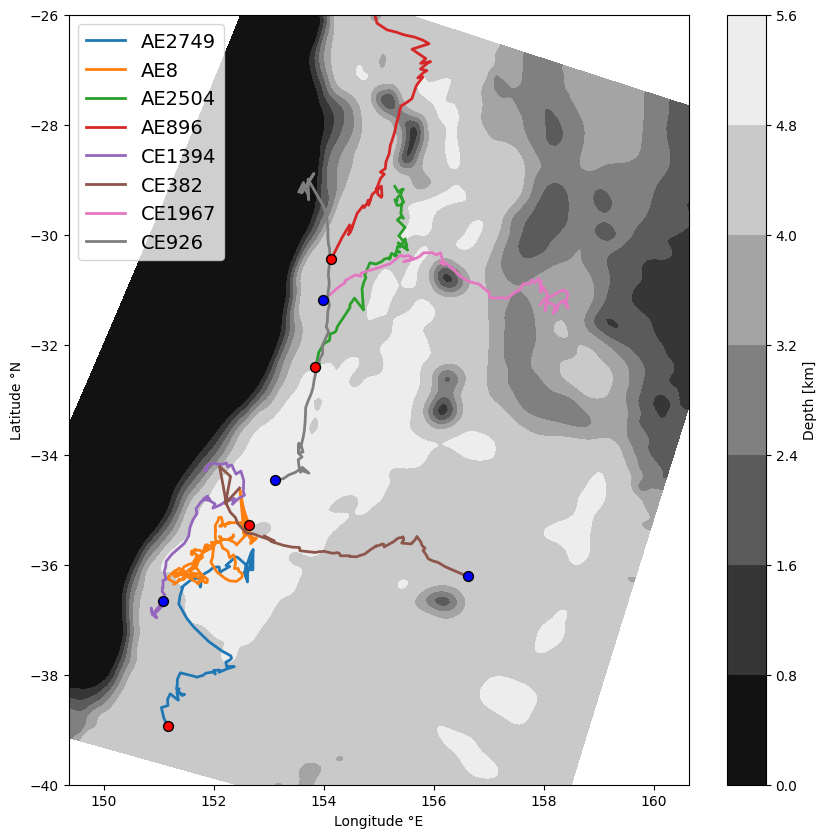

In [31]:
plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

for eddy in sample_eddies:
    df = df_eddies[df_eddies['ID']==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['Lon'], df['Lat'], label=f'{cyc}{eddy}',
            linewidth=2)
    plt.scatter(df.iloc[-1]['Lon'], df.iloc[-1]['Lat'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)

plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
plt.xlim(150, 160)
plt.ylim(-40, -26)
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')


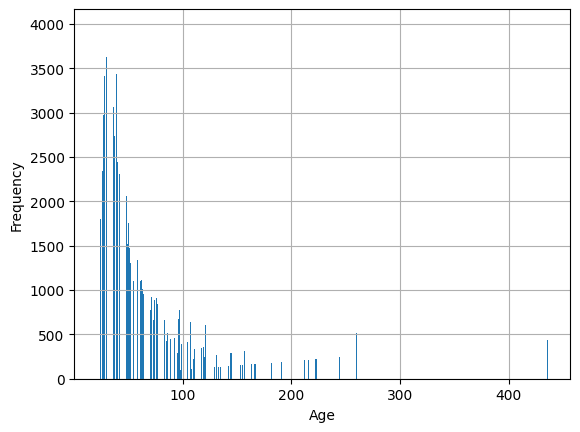

In [33]:
df_eddies['Age'].hist(bins=1000)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

(np.float64(0.0),
 np.float64(988.1356688684336),
 np.float64(0.0),
 np.float64(1561.702894718129))

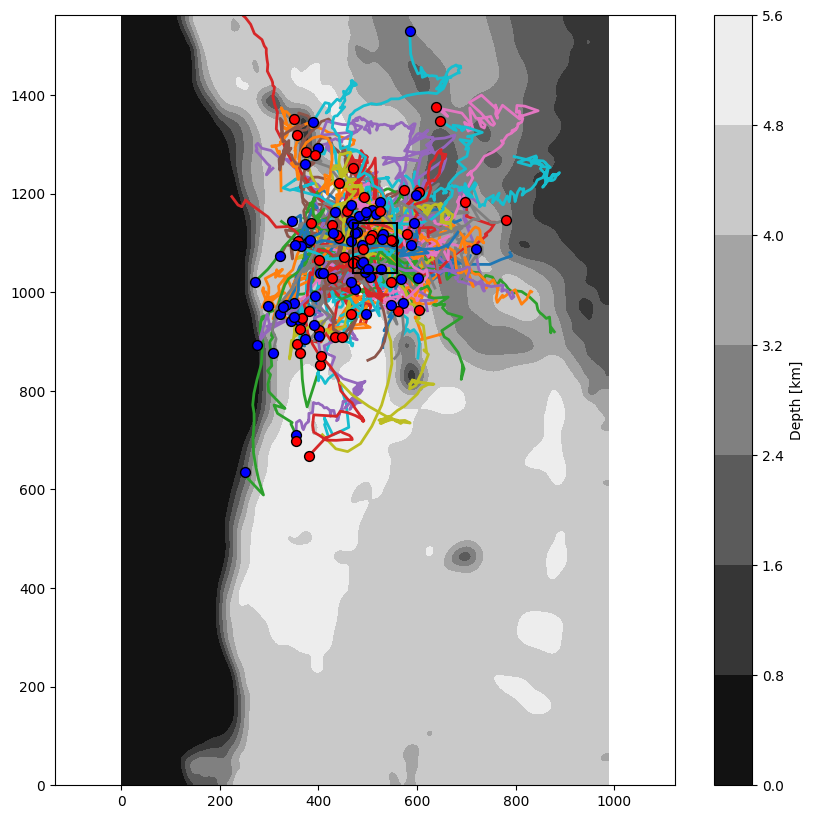

In [43]:
plt.figure(figsize=(10,10))
plt.contourf(X_grid, Y_grid, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

x1, x2 = 470, 560
y1, y2 = 1040, 1140



df_knoll = df_eddies[(df_eddies['x0']>=x1)&(df_eddies['x0']<=x2)&
                        (df_eddies['y0']>=y1)&(df_eddies['y0']<=y2)]
for eddy in df_knoll['ID'].unique():
    df = df_eddies[df_eddies['ID']==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['x0'], df['y0'], label=f'{cyc}{eddy}',
            linewidth=2)
    plt.scatter(df.iloc[-1]['x0'], df.iloc[-1]['y0'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)


plt.plot([x1, x2], [y1, y1], zorder=1000, color='k')
plt.plot([x1, x2], [y2, y2], zorder=1000, color='k')
plt.plot([x1, x1], [y1, y2], zorder=1000, color='k')
plt.plot([x2, x2], [y1, y2], zorder=1000, color='k')

# plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
# plt.xlim(150, 160)
# plt.ylim(-40, -26)
# plt.xlabel('Longitude °E')
# plt.ylabel('Latitude °N')


In [45]:
df_knoll

,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
1028,1503,19,CE,156.639208,-30.876839,191,220,556.138965,1088.743259,-0.011908,0.000388,-0.001540,-0.026897,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1029,1504,19,CE,156.618998,-30.736749,189,223,549.676802,1102.783669,-0.010650,0.000527,-0.001662,-0.024624,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1030,1505,19,CE,156.568703,-30.684717,188,224,543.371324,1106.592213,-0.010264,0.000448,-0.001954,-0.024435,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1031,1506,19,CE,156.513181,-30.653426,186,224,537.271900,1108.051587,-0.010101,0.000341,-0.002325,-0.024853,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1032,1507,19,CE,156.442251,-30.687905,185,223,531.948949,1102.105900,-0.010257,0.000119,-0.002446,-0.025405,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131829,10568,2940,CE,156.249012,-30.701934,181,222,514.803889,1094.292083,NaN,NaN,NaN,NaN,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
131830,10569,2940,CE,156.159332,-30.671460,179,222,505.621855,1094.545751,-0.003442,-0.003225,-0.006554,-0.019992,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
131831,10570,2940,CE,156.134556,-30.701845,179,221,504.381059,1090.548829,-0.004379,-0.002602,-0.006224,-0.021206,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
131832,10571,2940,CE,156.113722,-30.670573,178,221,501.437840,1093.142586,-0.004867,-0.001971,-0.005768,-0.021270,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
